In [1]:
from scipy import ndimage as ndi
import scipy.fftpack 
from skimage import data
from skimage.util import img_as_float
from skimage.filter import gabor_kernel
from PIL import Image
from object_parsing.src.image_objects import make_a_blank
import numpy as np
from experimental_design.src.experiments import make_design_matrix, fmri_experiment
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Parameters

In [2]:
savedir = '/Users/tnaselar/Data/Presentation/predictive.coding.match.nonmatch/spatial_frequency/'

##image parameters
STIMULUS_PIXELS = 768
VIEWING_ANGLE = 22.1 ##edge-to-edge of 768pix stim
PIXELS_PER_DEGREE = STIMULUS_PIXELS/VIEWING_ANGLE
print 'pixels per deg. %0.3f' %(PIXELS_PER_DEGREE)
PHASES = [0,pi] #rad
ORIENTATIONS = np.arange(0,180,45)
print 'orientations (deg): %s' %(ORIENTATIONS,)
FREQUENCIES = np.logspace(np.log10(0.01), np.log10(2.9),num=8)/PIXELS_PER_DEGREE #np.array([0, 0.04, 0.07, 0.14, 0.27, 0.55, 1.09])
print 'freqs: (cyc/deg): '+ '%s' %(FREQUENCIES*PIXELS_PER_DEGREE,)
isi_luminance = 127

##timing parameters
PHASE_CYCLES_PER_TR = 6 ##number of frames per tr
TR = 1.5
UNIQUE_GRATINGS = len(ORIENTATIONS)*len(FREQUENCIES)
LOOPS = 2 ##number of times each grating shown in a run.
ISI_LAM = 0.4
FADE_IN_FRAMES = 4
FADE_OUT_FRAMES = 6
RUNS = 4 ##
RUN_DURATION = ((UNIQUE_GRATINGS*(2+ISI_LAM))*LOOPS + FADE_IN_FRAMES+FADE_OUT_FRAMES)*TR/60.
print '%d unique gratings will be shown %d times per run' %(UNIQUE_GRATINGS,LOOPS)
print 'average run duration (min): %0.3f' %(RUN_DURATION)
print 'total time across runs (min): %0.3f, total reps of each grating across runs: %d' %(RUN_DURATION*RUNS, LOOPS*RUNS)
print 'given a TR of %0.3f, movie frame rate should be (Hz): %0.4f' %(TR, PHASE_CYCLES_PER_TR/TR)


pixels per deg. 34.751
orientations (deg): [  0  45  90 135]
freqs: (cyc/deg): [ 0.01        0.0224787   0.05052918  0.11358302  0.25531984  0.57392575
  1.29011034  2.9       ]
32 unique gratings will be shown 2 times per run
average run duration (min): 4.090
total time across runs (min): 16.360, total reps of each grating across runs: 8
given a TR of 1.500, movie frame rate should be (Hz): 4.0000


###Generate stimuli

In [3]:
def convert_array_to_image(x, mn=None,mx=None):
    if not mn:
        mn = np.min(x)
    x -= mn
    if not mx:
        mx = np.max(x)
    x /= mx
    x *= 255
    return Image.fromarray(np.uint8(x), mode='L')
    

In [4]:
def make_a_grating(theta, freq, phase_off, n_pix):
    [Xm, Ym] = np.meshgrid(range(0,n_pix), range(0,n_pix));  
    thetaRad = (theta / 360.) * 2*pi        # convert theta (orientation) to radians
    Xt = Xm * cos(thetaRad);                # compute proportion of Xm for given orientation
    Yt = Ym * sin(thetaRad);                # compute proportion of Ym for given orientation
    XYt = Xt + Yt;                      # sum X and Y components
    XYf = XYt * freq * 2*pi;                # convert to radians and scale by frequency
    grating = sin( XYf + phase_off)                   # make 2D sinewave
    return grating


In [5]:
def make_a_ripple(freq, phase_off, n_pix):
    if n_pix % 2 == 0:
        pix_min = -n_pix/2
        pix_max = -pix_min
    else:
        pix_min = -(n_pix-1)/2
        pix_max = -pix_min+1
    [Xm, Ym] = np.meshgrid(range(pix_min,pix_max), range(pix_min,pix_max));  
#     thetaRad = (theta / 360) * 2*pi;        # convert theta (orientation) to radians
    Dt = np.sin(np.sqrt(Xm**2+Ym**2)*freq*2*pi+phase_off)              # compute proportion of Xm for given orientation
    #Dtf = Dt * freq * 2*pi;                # convert to radians and scale by frequency
    #grating = sin( Dtf + phase_off);                   # make 2D sinewave
    return Dt

In [6]:
def make_gaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [7]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


In [8]:
def see_fft(image):
    F1 = scipy.fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = scipy.fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    freq_max = np.argmax(psd1D)

    # Now plot up both
    figure(1)
    clf()
    imshow( convert_array_to_image( image ), cmap=cm.gray)

    figure(2)
    clf()
    imshow( np.log10( psd2D ), cmap=cm.gray)

    figure(3)
    clf()
    semilogy( psd1D )
    xlabel('Spatial Frequency (cyc/image): peak = %0.3f' %(freq_max))
    ylabel('Power Spectrum')

In [9]:
def frame_name(freq,ori,phase_off):
    return 'grating_freq_%0.6f_ori_%0.2f_phase_%0.2f' %(freq,ori,phase_off)
    


####an example

cycle/deg: 0.090498


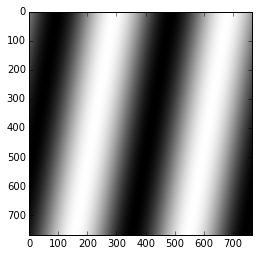

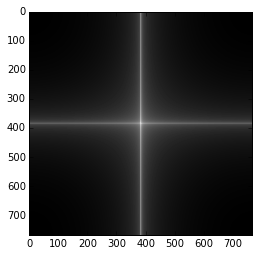

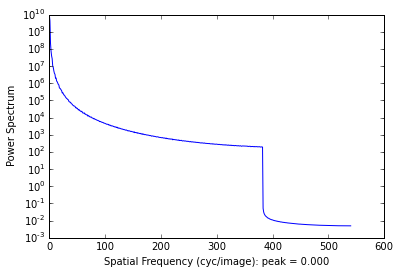

In [10]:
##examine in cyc/image

freq = 2./STIMULUS_PIXELS
see_fft(make_a_grating(10,freq,pi,STIMULUS_PIXELS))
print 'cycle/deg: %0.6f' %(freq*PIXELS_PER_DEGREE)

####generate the png files

In [11]:
###the pngs
lums = []
for ori in ORIENTATIONS:
    for freq in FREQUENCIES:
        for ph in PHASES:
            gr = make_a_grating(ori,freq,ph,STIMULUS_PIXELS)
            gr = convert_array_to_image(gr)
            lums += [np.mean(np.mean(gr))]
            gr.save(savedir+frame_name(freq,ori,ph)+'.png','png')

In [12]:
###isi screen
blank = make_a_blank(STIMULUS_PIXELS,isi_luminance,'L')
blank.save(savedir+'isi_screen.png',format='png')


In [13]:
#####note that luminance balanced across phase/freq

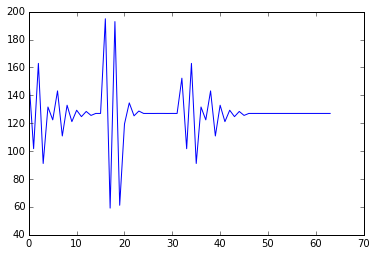

In [14]:
plot(lums)

###Experimental design

In [15]:
####generate frame file
cycle_list = []
for ori in ORIENTATIONS:
    for freq in FREQUENCIES:
        flash_list = []
        flash_count = 0
        while flash_count < PHASE_CYCLES_PER_TR:
            for ph in PHASES:
                flash_list.append(frame_name(freq,ori,ph)+'.png')
                flash_count += 1
        cycle_list.append(flash_list)
cycle_list.insert(0,['isi_screen.png']*PHASE_CYCLES_PER_TR)

for runs in range(RUNS):
    design_matrix = make_design_matrix(UNIQUE_GRATINGS,LOOPS,blank_states=[FADE_IN_FRAMES,ISI_LAM,FADE_OUT_FRAMES],seconds_per_state=TR)
    experiment = fmri_experiment(design_matrix,cycle_list,TR,design_matrix.shape[1])
    experiment.print_frame_list(savedir+'spatial_freq_run_%0.3d.txt' %(runs))
  


length of experiment: 158 states and 237.000000 seconds = 3.950000 mintues
length of experiment: 162 states and 243.000000 seconds = 4.050000 mintues
length of experiment: 172 states and 258.000000 seconds = 4.300000 mintues
length of experiment: 172 states and 258.000000 seconds = 4.300000 mintues
